## This notebook run code(s) on multiple cluster/session/animal

### This notebook is at the core of the pipeline of data processing. Do not play with it lightly inside the master folder (load_preprocess_mouse)

#### 1. Only modifiy if you are sure of what you are doing and that you are solving a bug
#### 2. If you do modify you MUST commit this modification using bitbucket
#### 3. If you want to play whis notebook (to understand it better) copy it on a toy folder distinct from the master folder
#### 4. If you want to modify this code (fix bug, improve, add attributes ...) it is recommanded  to first duplicate in a draft folder. Try to keep track of your change.
#### 5. When you are ready to commit : # clear all output, clean everything between hashtag 



### Batch: run code(s) on multiple cluster/session/animal

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#modules to find path of all sessions
import glob
import os
import numpy as np
import pickle

from IPython.display import clear_output, display, HTML

import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

## The lines below allow to run required notebook from the master folder
if "__file__" not in dir():
    
    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommunNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_mouse")
    os.chdir(CommunNoteBookesPath)   
    
    %run loadMouse_documentation.ipynb
    %run loadRawSpike_documentation.ipynb
    %run plotMouse_documentation.ipynb



def has_tag(root, animal, session, tagList):
    """ Test if the session has at least one of the tag in tagList
    tag = empty file with a specific name, in a session folder
    """
    fullPath = os.path.join(root, animal, "Experiments", session)
    fileList = os.listdir(fullPath)
    for tag in tagList:
        if tag in fileList:
            return True
    return False
    
param = {
    #Those parameters are overwrite if there is a .behav_param file
        "distanceToRun":100,
        "maxTrialDuration": 60,
        "valveONTime":50,
        "minInterTrialDuration":15,
        "immobilityDuration":2,
    
        #to read .eeg (put None to not read .eeg)
        "nChannelElectro":32,
        "channel_opto": -6, #not used
        "channel_lickBreak":-5,
        "channel_reward": -4, #not used currently
        "channel_sound": -3, #not used
        "channel_trialON": -2,
        "channel_beamBreak": -1,
    }


if platform.system()=='Linux':
    root="/data"
else:
    root="/Users/davidrobbe/Documents/Data/"
    
    
    # below you can manual modify the root folder. Before commit or push remove anything between these line and leave 1 line blank

    ##############################

    ############################## 
    
print("path to data is %s"%root)
print("")
print("importing done")

path to data is /data

importing done


## Loop through every session of a list of animals
### one session = one experiment = one folder = "MOUXXX_YYYY_MM_DD_HH_mm"

### Option A: Plot functions "one plot per session" 

A plot is done in a "plot function". You can do several plots at once (by giving a list of "plot function")  

For every session, the plots are saved in *RatXXX/Experiments/RatXXX_20.../nameOfPlot.png*  

An html page is created or updated: *RatXXX/Analysis/all_nameOfPlot.html*


In [4]:
#LINES BELOW ARE EXAMPLE. DO NOT MODIFY. MODIFY BETWEEN HASHTAG. When you commit erease between hashtag and let one empty line

#example of how to list  all animals
animalList = [os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]

# Define manually animalList if you don't want all the animals
animalList = ["MOU015","MOU016","MOU017","MOU018","MOU019","MOU028","MOU029"]

###############################
animalList = ["MOU147"]
###############################
#list of plot functions to do on each session
#those functions should take as arguments: data (+ optionnal keywords arguments)
#the functions can return False (then no plot will be saved)

plotFunctionList = [behavior_plot]#[GetAllSignificantModulation]

#Whether to read the existing pickle files (redo=False) or to reload from raw text files (redo=True)
redo = True
###############################

###############################
#Whether to overwrite the existing .png
override = True
###############################

###############################
#Whether to erase the existing .html
replaceHtml = True
###############################

###############################
#Wheter to run some batch on electrophy data
runElectrophyBatch=False
###############################

###############################
#list of tags (tag = empty file in the session folder with a specific name)
#leave empty for no tag
tagList = []

#---------------------------------------------------------------------------
print("List of animal to loop through: %s" % animalList)
print("Tag list: %s" % tagList)

#loop on animal
animalindex=1
for animal in animalList:
    print("Animal %s"%animal)
    print("%s out of %s" %(animalindex,len(animalList)))
    print("**********")
    animalindex += 1
    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)
    nbSession=len(sessionList)
    
    errorSession=[]
    
    if replaceHtml:
        for plotFunction in plotFunctionList:
            name = str(plotFunction.__name__)

            #html for the animal
            generalName = "all_" + name
            AnalysisFolder = os.path.join(root, animal, "Analysis")
            generalPath = os.path.join(AnalysisFolder, generalName+".html")
            if os.path.exists(generalPath):
                os.remove(generalPath)
    
    #loop through sessions
    for index, session in enumerate(sessionList):
        
        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
        
        print("Session %s/%s: %s"%(index+1,nbSession,session))
        #load data for this session (add redoPreprocess=True to overwrite preprocess)
        try:
            sessionData=Data(root, animal, session, param=param, redoPreprocess=redo)
            
            
        except Exception as e:
            display(HTML("<b> An error happened, skip session. Error message: </b>"))
            display(HTML("<b>"+e.__class__.__name__+": "+str(e)+"</b>"))
            errorSession.append(session)
            print("--------")
            continue
            
        #skip if training data or no break time
        if (not sessionData.hasBehavior) or sessionData.isLickTraining:
            print("Training or unvalid session, skipped")
            print("--------")
            continue
            
        #skip if short session
        if sessionData.totalDurationMin<5:
            print("Session %s last less than 5 minutes, skipped"%session)
            print("--------")
            continue
        
        
        #plot the data (add name="myNewName" to change the name of the html, add override=True to redo the plots)
        sessionData.plot_session_png_html(plotFunctionList,override=override)
        
        
        if runElectrophyBatch:
        
            print("Session %s is beeing analyzed with  meanFiringRatevsRunandImmoNorm function"%session)
            meanFiringRatevsRunandImmoNorm(sessionData, saveAsPickle=True, redo=True, binSize=0.25, SideLength=3,showplot=False)

            print("Session %s is beeing analyzed with  GetAllSignificantModulation function"%session)
            GetAllSignificantModulation(sessionData,redo=True)


            print("Session %s is beeing analyzed with  GetAllCorrCoefFRateVsKinematic function"%session)
            GetAllCorrCoefFRateVsKinematic(sessionData,redo=True)
        
        
        
        print("--------")

    clear_output()
print("Done")
if errorSession:
    display(HTML("<b> An error happened for the following session(s):"))
    print("\n".join(errorSession))

Done


### Option B: Plot functions "one plot per cluster"

A plot is done in a "plot function", either defined here or in another .py file (ex: plotData.py). You can do several plots at once (by giving a list of "plot function")  

For every session, the plots are saved in *RatXXX/Experiments/RatXXX_20.../plots/shankX_clusterX_nameOfPlot.png*  

Two html pages are created or updated: 

  - *RatXXX/Experiments/RatXXX_20.../nameOfPlot.html*: all plots for session ("session html")
  - *RatXXX/Analysis/all_nameOfPlot.html*: links to every "session html" for this rat

In [ ]:
#LINES BELOW ARE EXAMPLE. DO NOT MODIFY. MODIFY BETWEEN HASHTAG. When you commit erease between hashtag and let one empty line

#example of how to list  all animals
animalList = [os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]

# Define manually animalList if you don't want all the animals
animalList = ["MOU015","MOU016","MOU017","MOU018","MOU019","MOU028","MOU029"]

###############################

###############################

#list of plot functions to do on each session
#those functions should take as arguments: data,shank,cluster,group (+ optionnal keywords arguments)
#the functions can return False (then no plot will be saved)
plotFunctionList=[cluster_ratevskinematicplot]

#Whether to read the existing pickle files (redo=False) or to reload from raw text files (redo=True)
redo=True

#Whether to overwrite the existing .png
override=True

#list of tags (tag = empty file in the session folder with a specific name)
#leave empty for no tag
tagList = ["GoodPerfo"]

#---------------------------------------------------------------------------
#loop on animal
for animal in animalList:
    print("animal %s"%animal)
    print("**********")

    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)
    nbSession=len(sessionList)
    
    errorSession=[]

    #loop through sessions
    for index,session in enumerate(sessionList):
        
        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
        
        print("Session %s/%s: %s"%(index+1,nbSession,session))
        
        #load data for this session (add redoPreprocess=True to overwrite preprocess)
        try:
            sessionData=Data(root,animal,session,param=param,redoPreprocess=redo)
            
        except Exception as e:
            display(HTML("<b> An error happened, skip session. Error message: </b>"))
            display(HTML("<b>"+e.__class__.__name__+": "+str(e)+"</b>"))
            errorSession.append(session)
            print("--------")
            continue
            
        #skip if training data or no break time
        if (not sessionData.hasBehavior) or sessionData.isLickTraining:
            print("Training or unvalid session, skipped")
            print("--------")
            continue
            
        #skip if short session
        if sessionData.totalDurationMin<5:
            print("Session %s last less than 5 minutes, skipped"%session)
            print("--------")
            continue
            
        if sessionData.hasSpike:
            #plot the data (add name="myNewName" to change the name of the html, add override=True to redo the plots)
            # groupList can be "Good", ["Good","MUA"],... No groupList -> do every group
            #sessionData.plot_all_clusters_png_html(plotFunctionList, override=override, groupList="Good")
            sessionData.plot_all_clusters_png_html_insinglelocation(plotFunctionList, override=override, groupList="Good")

        print("--------")
        
print("Done")
if errorSession:
    display(HTML("<b> An error happened for the following session(s):"))
    print("\n".join(errorSession))

### Option C: Statistic for one mouse across sessions

MOU147
0 % correct trial x % correct stop
1 Good trials Per 5 Min (trials/5min)
2 Immobility Fraction in interTrial
3 Immobility Fraction/ Median Trial Duration
4 Median InterTrial Duration After Correct Trials (s)
5 Median Trial Duration (s)
6 Median trial + interTrial duration (s)
7 Overall Running Speed (cm/s)
8 Percent Correct Trial (%)
9 Percentage Correct Stop (%)
10 Real distance To Run (cm)
11 RunAndStopIndex
12 Running Speed After Sound (5.0s after trial start, cm/s)
13 Running Speed Before Reward (5.0s before reward, cm/s)
14 Running Speed End InterTrial (5.0s before end, cm/s)
15 Speed after sound/ Speed interTrial
16 Trials Per 5 Min (trials/5min)
Save pickle: /data/MOU147/Analysis/learningStats.p


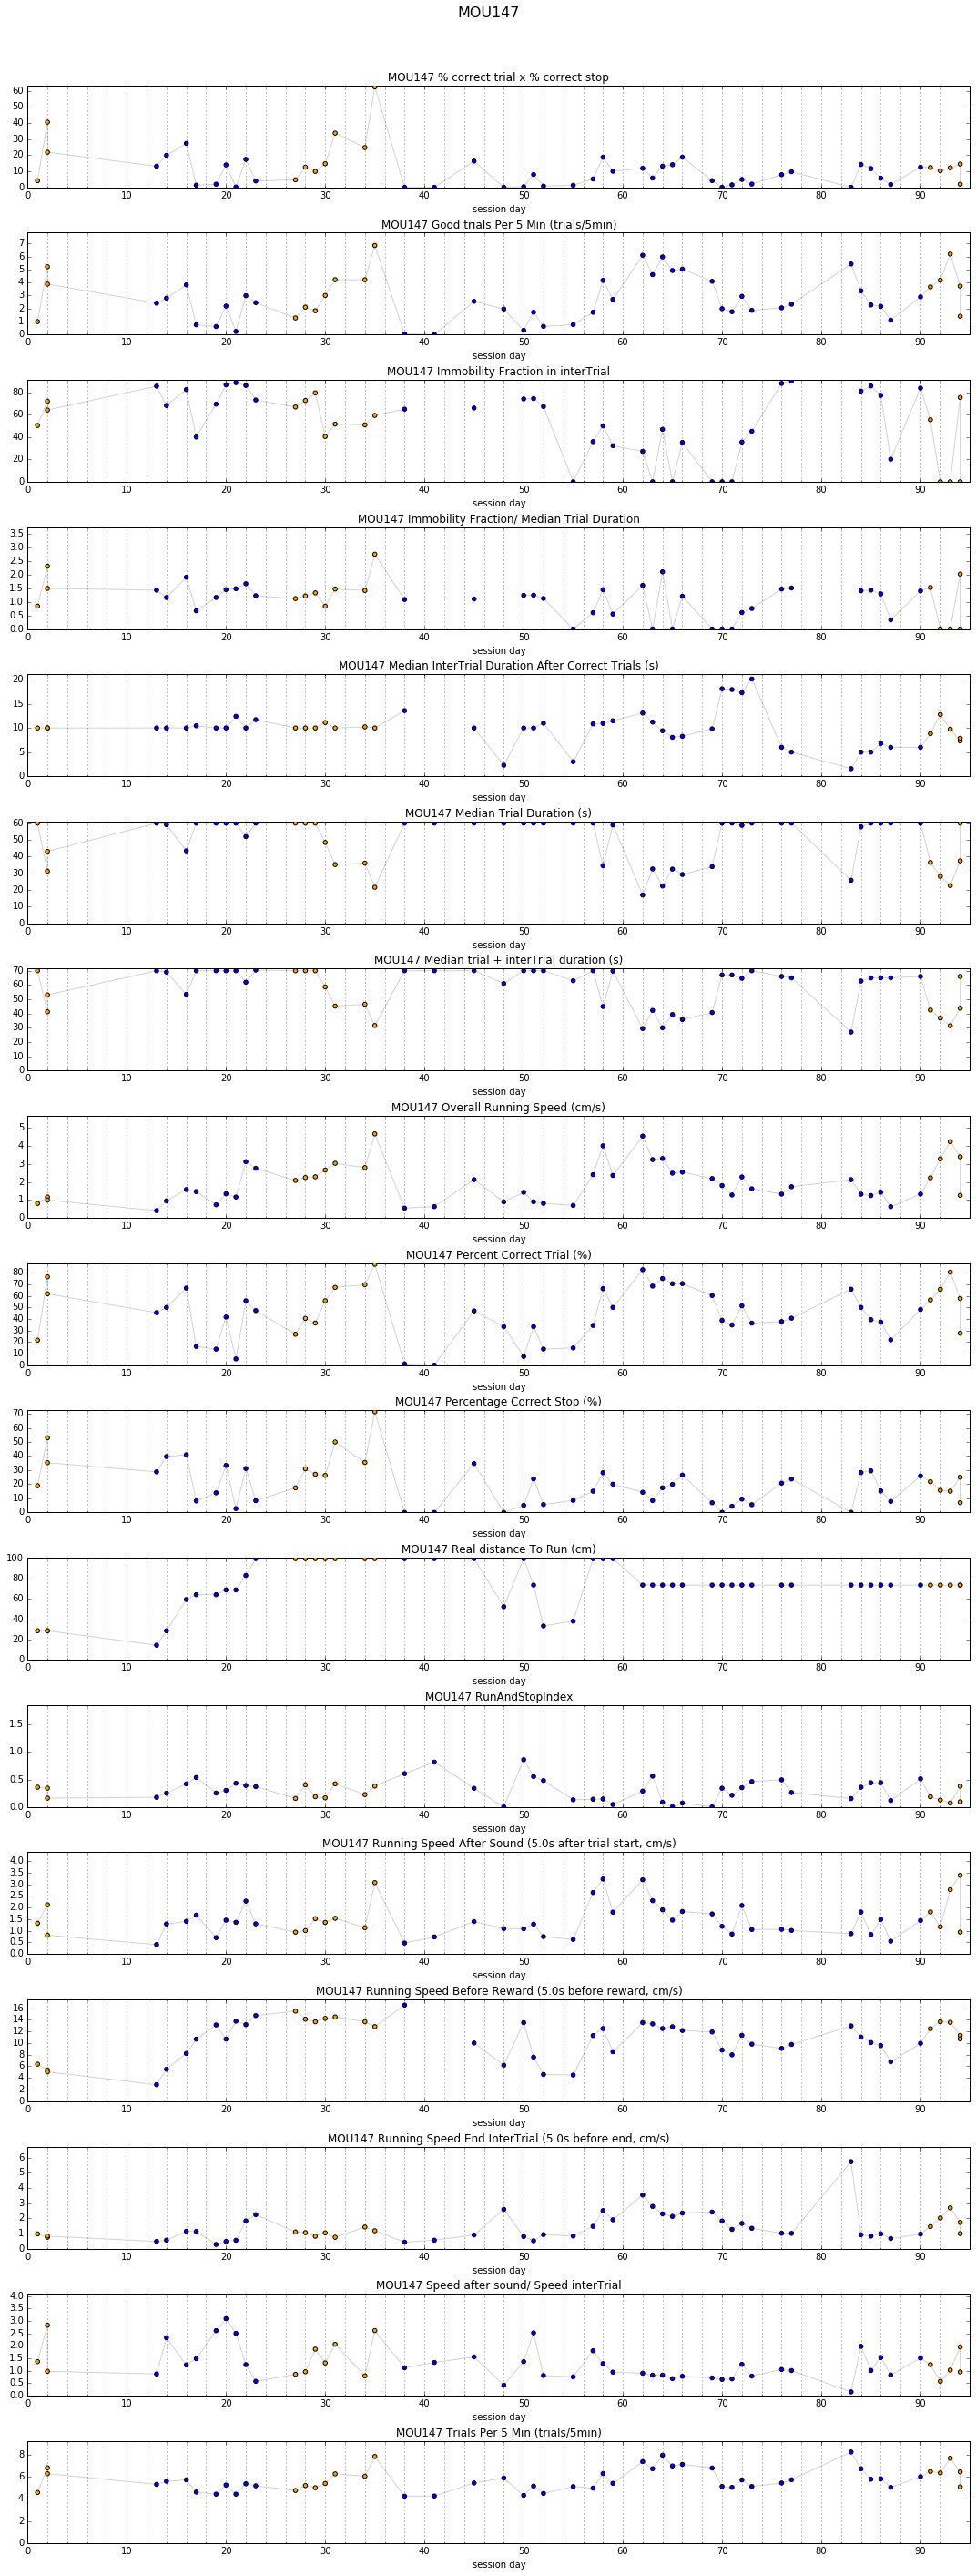

In [5]:
def mouse_statistics(root, animal, parameter={}, redoPreprocess=False, savePickleAndFig=True):
    results={}
    days=[]
    colo=[]
    sessionNames=[]
    

    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)
    if not sessionList:
        print("no sessions")
        return

    #loop through sessions
    for session in sessionList:  
        print(session)
        #load data for this session (add redoPreprocess=True to overwrite preprocess)
        sessionData=Data(root,animal,session,parameter,redoPreprocess=redoPreprocess)
        if (not sessionData.hasBehavior) or sessionData.isLickTraining:
            continue
        if sessionData.totalDurationMin<5:
            print("Session %s last less than 5 minutes, skipped"%session)
            continue
            
        days.append(sessionData.daySinceStart)
        sessionNames.append(session)
        if sessionData.hasOptogenetic:
            colo.append("orange")
        elif (sessionData.hasSpike) or (glob.glob(sessionData.fullPath+".dat")):
            colo.append("red")
        else:
            colo.append("blue")
        
        #add data in results
        for key in sessionData.taskResults:
            try:
                results[key].append(sessionData.taskResults[key])
            except KeyError:
                results[key]=[sessionData.taskResults[key]]
                
    clear_output()
    
    # One subplot for every key in results
    nbCol=1
    nbLine=len(results)//nbCol+len(results)%nbCol
    length=len(days)
    
    plt.figure(figsize=(15, 40))
    index=0
    print(animal)
    for key in sorted(results):
        if len(results[key])!=length:
            continue
        print(index,key)
        ax=plt.subplot(nbLine,nbCol,index+1)
        ax.plot(days,results[key],color="lightgrey")
        
        #fix color issue with nan
        colorNonan=[c for c,res in zip(colo,results[key]) if not np.isnan(res)]
        ax.scatter(days,results[key],c=colorNonan,zorder=10)
        
        ax.set_title(animal+" "+key)
        ax.set_ylim(0,max(results[key])+1)
        ax.set_xlabel("session day")
        ax.xaxis.grid(which='minor')   

        major_ticks = np.arange(0, days[-1], 10)                                              
        minor_ticks = np.arange(0, days[-1], 2)                                               
        ax.set_xticks(major_ticks)                                                       
        ax.set_xticks(minor_ticks, minor=True)  
        ax.set_xlim([0,days[-1]+1])
        index+=1

    plt.tight_layout()            
    plt.subplots_adjust(top=0.95)
    plt.suptitle(animal,fontsize=16)
    
    
    results["days"]=days
    results["session"]=sessionNames
    
    #save plot and pickle
    if savePickleAndFig:    
        path=os.path.join(root,animal,"Analysis")
        if not os.path.exists(path):
            os.mkdir(path)
        pathFig=os.path.join(path,"LearningAcrossSession.png")
        plt.savefig(pathFig)

        path=os.path.join(path,"learningStats.p")
        with open(path, 'wb') as f:
            pickle.dump(results, f)
        print("Save pickle: %s"%path)
    
    return results

#--------------------------------------------------------------------------------------------------------
#LINES BELOW ARE EXAMPLE. DO NOT MODIFY. MODIFY BETWEEN HASHTAG. When you commit erease between hashtag and let one empty line

#example of how to list  all animals
animalList = [os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]

# Define manually animalList if you don't want all the animals
animalList = ["MOU015","MOU016","MOU017","MOU018","MOU019","MOU028","MOU029"]

###############################
animalList = ["MOU147"]
###############################



errors=[]
#one plot per mouse
for animal in animalList:
    try:
        results=mouse_statistics(root,animal,param,redoPreprocess=False,savePickleAndFig=True)
    except Exception as e:
        errors.append((animal, e, session))
        continue
        
#display errors
for a, e, session in errors:
    display(HTML("<b> Skipped animal %s. Error message: </b>"%(a)))
    display(HTML("<b>"+e.__class__.__name__+": "+str(e)+"</b>"))


### Option D: Statistics for groups of mice across sessions

In [ ]:
def get_mice_group_statistic(root,animalList,parameter={},redo=False):
    allResults={}
    # Load all statistics
    for animal in animalList:
        pathPickle=os.path.join(root,animal,"Analysis","learningStats.p")
        if os.path.exists(pathPickle) and (not redo):
            with open(pathPickle,"rb") as f:
                results=pickle.load(f)
        else:
            results=mouse_statistics(root,animal,parameter,redo)
            clear_output()
            plt.close()
        if not allResults:
            #first animal
            allResults={key: {animal:results[key]} for key in results}
        else:
            for key in allResults:
                allResults[key][animal]=results[key]              
    #find maximum number of session
    nSessionMax=0
    for animal in allResults["days"]:
        m=len(allResults["days"][animal])
        nSessionMax=max(m,nSessionMax)
    #padd with nan when less session than maximum
    for key in allResults:
        for animal in allResults[key]:
            nSession=len(allResults[key][animal])
            allResults[key][animal].extend([np.nan]*(nSessionMax-nSession))                
    return allResults,nSessionMax

def plot_one_key(xaxis,keyResult,animalList,colorList,color="blue",ax=None):
    if ax is None:
        ax=plt.gca()
    #compute mean
    keyRes=np.asarray(list(keyResult.values()))
    meanKeyRes=np.nanmean(keyRes,axis=0)
    
    # get max and min
    
    AllMaxMinKeyRes=np.nanpercentile(keyRes,[0,100],axis=0)
    MaxRes=max(AllMaxMinKeyRes[1])
    MinRes=min(AllMaxMinKeyRes[0])
    
    #plot mean
    ax.plot(xaxis,meanKeyRes,color="grey")
    ax.scatter(xaxis,meanKeyRes,c=color,zorder=10)
    ax.set_ylim(MinRes,MaxRes)
    #plot each animal in a different color
    for color,animal in zip(colorList,keyResult):
        ax.scatter(xaxis,keyResult[animal],marker="+",color=color)
    
    return keyRes
        
def plot_mean_all_animals(root,animalList,parameter={},redo=False):
    allResults,nSessionMax=get_mice_group_statistic(root,animalList,parameter,redo)
    xaxis=np.arange(1,nSessionMax+1,1) 
    # plot
    nbCol=1
    nbLine=len(allResults)//nbCol+len(allResults)%nbCol
    plt.figure(figsize=(10, 40))
    colors = cm.rainbow(np.linspace(0, 1, len(animalList)))
    # one subplot for each key   
    for index,key in enumerate(sorted(allResults)):
        ax=plt.subplot(nbLine,nbCol,index+1)
        plot_one_key(xaxis,allResults[key],animalList,colors,ax=ax)
        ax.set_title(key)
        ax.set_xlim(0,nSessionMax+1)
        ax.set_xlabel("number of session since start")
    plt.tight_layout()            
    plt.subplots_adjust(top=0.95)
    return allResults,xaxis
    
def plot_mean_subgroup_animal(root,groups,parameter={},redo=False):
    #divide input dictionary
    animalGroup={key: groups[key][2] for key in groups}
    colorMapGroup={key: groups[key][0] for key in groups}
    colorGroup={key: groups[key][1] for key in groups}   
    allResults={}
    nSessionMax={}
    # invert dict {"stat":{ "group": {"animal": [values] }}}
    for group in animalGroup:
        results,nSessionMax[group]=get_mice_group_statistic(root,animalGroup[group],parameter,redo)
        if not allResults:
            #firt group
            allResults={key: {group:results[key]} for key in results}
        else:
            for key in allResults:
                allResults[key][group]=results[key]                   
    nbCol=1
    nbLine=len(allResults)//nbCol+len(allResults)%nbCol
    plt.figure(figsize=(10, 40))    
    colors={}
    for group in animalGroup:
        colors[group] = colorMapGroup[group](np.linspace(0, 1, len(animalGroup[group])))                           
    for index,key in enumerate(sorted(allResults)):
        ax=plt.subplot(nbLine,nbCol,index+1)
        ax.set_title(key)
        for group in allResults[key]:
            xaxis=np.arange(1,nSessionMax[group]+1,1) 
            plot_one_key(xaxis,allResults[key][group],animalGroup[group],
                         colors[group],color=colorGroup[group],ax=ax)
            ax.set_xlabel("number of session since start")
            ax.set_xlim([0,max(list(nSessionMax.values()))])
    plt.tight_layout()            
    plt.subplots_adjust(top=0.95)

In [ ]:
# Option 1: plot the mean statistics for a list
animalList=["MOU015","MOU016","MOU017","MOU018","MOU019","MOU028","MOU029"]

###############################

###############################


allResults,xaxis=plot_mean_all_animals(root,animalList)

In [ ]:
# Option 2: plot the mean by group
# For each group, you need to define ("name": (cm.colorMap, "color for the mean", [list of animal]))
groups={
    "group1":(cm.winter,"blue",["MOU015","MOU016","MOU017","MOU018","MOU019"]),
    "group2":(cm.hot,"red", ["MOU028","MOU029"]),    #http://matplotlib.org/examples/color/colormaps_reference.html
}

#create your own groups :
###############################

###############################


plot_mean_subgroup_animal(root,groups)

## Mean firing rate during run/immobility vs spike caracteristic

"baseline-peak amplitude"  
"peak to valley amplitude"  
"half-width"  

IN PROGRESS (DAVID)

In [ ]:
def firing_rate_vs_spike_caracteristic(root, animalList, parameter={}, groupList=["Good"], sample=150, redo=False, 
                               saveAsPickle=True, immobility=False, caracteristic="half-width"):
    allFr = []
    allSw = []
        
    for animal in animalList:
        print("Animal", animal)
        #Get the list of all session
        sessionList = [os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
        sessionList = sorted(sessionList)
        if not sessionList:
            print("no sessions")
            return

        #loop through sessions
        for session in sessionList:  
            print(session)
            #load data for this session (add redoPreprocess=True to overwrite preprocess)
            sessionData = Data(root, animal, session, parameter, redoPreprocess=redo)
            if (not sessionData.hasBehavior) or sessionData.isLickTraining:
                continue
            if sessionData.totalDurationMin<5:
                print("Session %s last less than 5 minutes, skipped"%session)
                continue
            if not sessionData.hasSpike:
                print("no spike")
                continue

            resFiring = meanFiringRatevsRunandImmoNorm(sessionData, groupList=groupList, redo=redo, 
                                                       saveAsPickle=saveAsPickle)
            resWave = get_all_mean_waveforms(sessionData, groupList=groupList, sample=sample, redo=redo, 
                                             saveAsPickle=saveAsPickle)

            if immobility:
                meanFiring = resFiring["meanFiringRateDuringImmoNorm"]
                xlabel = "mean firing rate during immobility"
            else:
                meanFiring = resFiring["meanFiringRateDuringRunNorm"]
                xlabel = "mean firing rate during running"

            nSideBin = resFiring["nSideBinForNormPlots"]

            for shank in meanFiring:
                for clu in meanFiring[shank]:
                    fr = np.mean(meanFiring[shank][clu][nSideBin+1 : -nSideBin])
                    allFr.append(fr)
                    sw = resWave[shank][clu][caracteristic]
                    allSw.append(sw)
            print("------")
            
    clear_output()
    plt.scatter(allFr, allSw)
    plt.xlabel(xlabel)
    plt.ylabel("spike " + caracteristic)
    plt.title("%i clusters" %len(allFr))
    
#--------------------------------------------------------------------------------------------------------
animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]

# NB: when changing groupList, you need to put redo=True

plt.figure(figsize=(15,5))
plt.subplot(121)
firing_rate_vs_spike_caracteristic(root, animalList, groupList=["Good"], immobility=True)

plt.subplot(122)
firing_rate_vs_spike_caracteristic(root, animalList, groupList=["Good"], immobility=False)
